# Quick graph creation

#### Libraries

In [1]:
import spacy
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

2022-01-12 15:57:14.514821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-12 15:57:14.514856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/becode/.local/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
nlp = spacy.load('en_core_web_sm')
doc1 = nlp("The 22-year-old recently won ATP Challenger tournament.")
for tok in doc1:
  print(tok.text, "...", tok.dep_)

The ... det
22 ... nummod
- ... punct
year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


We wanted to extract “22-year-old” instead.

The rule can be something like this — extract the subject/object along with its modifiers and also extract the punctuation marks between them.
In short, we will use dependency parsing to extract entities.

#### Extract Relations

Entity extraction is half the job done. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

In [3]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


To extract the relation, we have to find the ROOT of the sentence (which is also the verb of the sentence). Hence, the relation extracted from this sentence would be “won”.

#### Build a Knowledge Graph from Text Data

The following dataset exists of 4,300 sentences from over 500 Wikipedia articles. Each of these sentences contains exactly two entities – one subject and one object. 

In [32]:
# import wikipedia sentences
candidate_sentences = pd.read_excel("../assets/preprocessed_text.xlsx")
candidate_sentences.shape

(10788, 3)

In [33]:
candidate_sentences

,ids,categories,text
0,test/14826,['trade'],"Mounting trade friction between the U.S. And Japan has raised fears among many of Asias exporting nations that the row could inflict far-reaching economic damage, businessmen and officials said..."
1,test/14828,['grain'],"A survey of 19 provinces and seven cities showed vermin consume between seven and 12 pct of Chinas grain stocks, the China Daily said. It also said that each year 1.575 mln tonnes, or 25 pct, o..."
2,test/14829,"['crude', 'nat-gas']","The Ministry of International Trade and Industry (MITI) will revise its long-term energy supply/demand outlook by August to meet a forecast downtrend in Japanese energy demand, ministry officia..."
3,test/14832,"['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade']","Thailands trade deficit widened to 4.5 billion baht in the first quarter of 1987 from 2.1 billion a year ago, the Business Economics Department said. It said Janunary/March imports rose to 65.1..."
4,test/14833,"['palm-oil', 'veg-oil']","Indonesia expects crude palm oil (CPO) prices to rise sharply to between 450 and 550 dlrs a tonne FOB sometime this year because of better European demand and a fall in Malaysian output, Hasrul..."
...,...,...,...
10783,training/999,"['interest', 'money-fx']",The Bank of England said it had revised its forecast of the shortage in the money market down to 450 mln stg before taking account of its morning operations. At noon the bank had estimated the ...
10784,training/9992,['earn'],Qtly div 25 cts vs 25 cts prior Pay April 13 Record April Six
10785,training/9993,['earn'],Qtly div 12 cts vs 12 cts prior Pay April 21 Record April Seven
10786,training/9994,['earn'],"Shr loss six cts vs loss 18 cts Net loss 89,478 vs loss 178,507 Revs 3,894,844 vs 1,964,141 Avg shrs 1,582,790 vs one mln Year Shr loss 43 cts vs loss 81 cts Net loss 534,099 vs loss 811,836..."


Inspect a few sentences

In [35]:
candidate_sentences['text'].sample(5)

3849    Cable and Wireless Plc CAWL.L said  proposals to resolve a dispute over entry to Japans  telecommunications market were not acceptable.  A company spokesman said the proposals appear to have been ...
4710    Shr loss 6.48 DLS VS PROFIT 23 CTS  Net loss 110.6 mln vs profit 4.1 mln  Revs 74.0 mln vs 152.0 mln  Year  Shr loss 6.52 dlrs vs profit 3.87 dlrs  net loss 111.2 mln vs profit 64.2 mln  Revs 501....
5084    The Bank of Japan intervened in early  afternoon Tokyo trading to support the dollar against active  selling by institutional investors and speculative selling by  overseas operators, dealers said...
67      The Bank of England said it provided the  market with further help totalling 166 mln stg during the  afternoon.  In band one, it bought 31 mln stg of treasury bills and  three mln stg of bank bill...
5386                       Toronto Sun Publishing Corp said it  planned a two-for-one split of its common shares, subject to  regulatory approval and approval by shareh

check the subject and object of one of these sentences. Ideally, there should be one subject and one object in the sentence

In [36]:
doc = nlp("Mitsubishi Heavy Industries Ltd MITH.T  (MHI) and C. Itoh and Co Ltd CITT.T have decided to sell  their combined 65 pct stake in Indonesias Pt Triguna Utama  Machinery Industries to Caterpillar")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Mitsubishi ... compound
Heavy ... compound
Industries ... compound
Ltd ... nsubj
MITH.T ... compound
  ... dep
( ... punct
MHI ... appos
) ... punct
and ... cc
C. ... compound
Itoh ... conj
and ... cc
Co ... compound
Ltd ... compound
CITT.T ... conj
have ... aux
decided ... ROOT
to ... aux
sell ... xcomp
  ... dep
their ... poss
combined ... amod
65 ... nummod
pct ... compound
stake ... dobj
in ... prep
Indonesias ... compound
Pt ... compound
Triguna ... compound
Utama ... nmod
  ... dep
Machinery ... compound
Industries ... pobj
to ... prep
Caterpillar ... pobj


 There is only one subject (‘process’) and only one object (‘standard’). You can check for other sentences in a similar manner.

#### Entity Pairs Extraction

To build a knowledge graph, the most important things are the nodes and the edges between them.

These nodes are going to be the entities that are present in the Wikipedia sentences. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered. 

However, there are a few challenges ⁠— an entity can span across multiple words, eg., “red wine”, and the dependency parsers tag only the individual words as subjects or objects.

The function below is used to extract the subject and the object (entities) from a sentence while also overcoming the challenges mentioned above. 

In [37]:
sent= "The 22-year-old recently won ATP Challenger tournament."

In [38]:
def get_entities(sent):
    
    
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""
    
###########################
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
                    
            
    # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
    
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
            modifier = prv_tok_text + " "+ tok.text
            
            
        ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""
            
        ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text
            
        ## chunk 5  
        # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
  ##    ###########################################################

    return [ent1.strip(), ent2.strip()]

In [39]:
get_entities(sent)

['year  old', 'Challenger tournament ATP Challenger tournament']

we can use this function to extract these entity pairs for all the sentences in our data

In [66]:
entity_pairs = []

for i in tqdm(candidate_sentences["text"]):
  entity_pairs.append(get_entities(i))

100%|█████████████████████████████████████| 10788/10788 [06:07<00:00, 29.37it/s]


In [67]:
entity_pairs

[['Michael Smith Representative Michael Smith', 'week International dispute'],
 ['government', 'further paper details'],
 ['21 hour they', 'hour basis hour oil'],
 ['seven  Products', '57 export pct'],
 ['Indonesian export exports', 'bank   bank figures'],
 ['it', 'shipping movements shipping movements'],
 ['Total 6.87 membership', 'exchange'],
 ['shipment', 'April'],
 ['ore   ore capacity', 'first treatment mid-1988'],
 ['strategy', 'that'],
 ['thirds majority thirds majority', 'extension'],
 ['dealers', 'call money call money'],
 ['ore tonnage ore tonnage', 'least operations 1993'],
 ['further  It', 'further  details'],
 ['Farm products U.S. Farm issues', 'same  table'],
 ['pct stake pct it', 'enlarged dividend capital'],
 ['5.8 timber Interest', 'mln debit mln debit'],
 ['Partly bankers offsetting', 'mln  system'],
 ['proper  Kim', 'proper  level'],
 ['late Alberta statement', 'late Alberta 1989'],
 ['year Western It', 'gold project gold project'],
 ['recent industry data', 'pct ris

clean the entity pairs..

#### Relation / Predicate Extraction

This is going to be a very interesting aspect of this article. Our hypothesis is that the predicate is actually the main verb in a sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching

In [71]:
sent= candidate_sentences["text"]

In [72]:
def get_relation(entity_pairs):
    
    doc = nlp(sent)
    
    # Matcher class object 
    matcher = Matcher(nlp.vocab)
    
    #define the pattern 
    pattern = [#{'DEP':'ROOT'}, 
               {'DEP':'prep','OP':"?"},
               {'DEP':'agent','OP':"?"},  
               {'POS':'VERB'#,'OP':"?"
               }] 
    
    matcher.add("matching_1", [pattern]) 
    matches = matcher(doc)
    
    k= len(matches) - 1
    
    span= doc[matches[k][1]:matches[k][2]]
    rel= [doc[matches[k][1]: matches[k][2]] for k in range(len(matches))]
    
    return rel

In [74]:
get_relation(entity_pairs)

ValueError: [E866] Expected a string or 'Doc' as input, but got: <class 'pandas.core.series.Series'>.

In [46]:
#get_relation("John completed the task")

In [55]:
relations = [get_relation(i) for i in tqdm(entity_pairs)]

100%|████████████████████████████████████| 10788/10788 [01:42<00:00, 105.52it/s]


In [57]:
pd.Series(relations).value_counts()[:50]

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
[(won)]    1
dtype: int64

#### Build a Knowledge Graph

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates

In [58]:
entity_pairs

[['Michael Smith Representative Michael Smith', 'week International dispute'],
 ['government', 'further paper details'],
 ['21 hour they', 'hour basis hour oil'],
 ['seven  Products', '57 export pct'],
 ['Indonesian export exports', 'bank   bank figures'],
 ['it', 'shipping movements shipping movements'],
 ['Total 6.87 membership', 'exchange'],
 ['shipment', 'April'],
 ['ore   ore capacity', 'first treatment mid-1988'],
 ['strategy', 'that'],
 ['thirds majority thirds majority', 'extension'],
 ['dealers', 'call money call money'],
 ['ore tonnage ore tonnage', 'least operations 1993'],
 ['further  It', 'further  details'],
 ['Farm products U.S. Farm issues', 'same  table'],
 ['pct stake pct it', 'enlarged dividend capital'],
 ['5.8 timber Interest', 'mln debit mln debit'],
 ['Partly bankers offsetting', 'mln  system'],
 ['proper  Kim', 'proper  level'],
 ['late Alberta statement', 'late Alberta 1989'],
 ['year Western It', 'gold project gold project'],
 ['recent industry data', 'pct ris

In [59]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [63]:
kg_df

,source,target,edge
0,Michael Smith Representative Michael Smith,week International dispute,[(won)]
1,government,further paper details,[(won)]
2,21 hour they,hour basis hour oil,[(won)]
3,seven Products,57 export pct,[(won)]
4,Indonesian export exports,bank bank figures,[(won)]
...,...,...,...
10783,morning operations morning bank,500 mln,[(won)]
10784,,25 cts,[(won)]
10785,,12 cts,[(won)]
10786,,"534,099 Shr loss",[(won)]


Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.
It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another.

In [60]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

#### plot

In [61]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

KeyboardInterrupt: 

<Figure size 864x864 with 0 Axes>

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

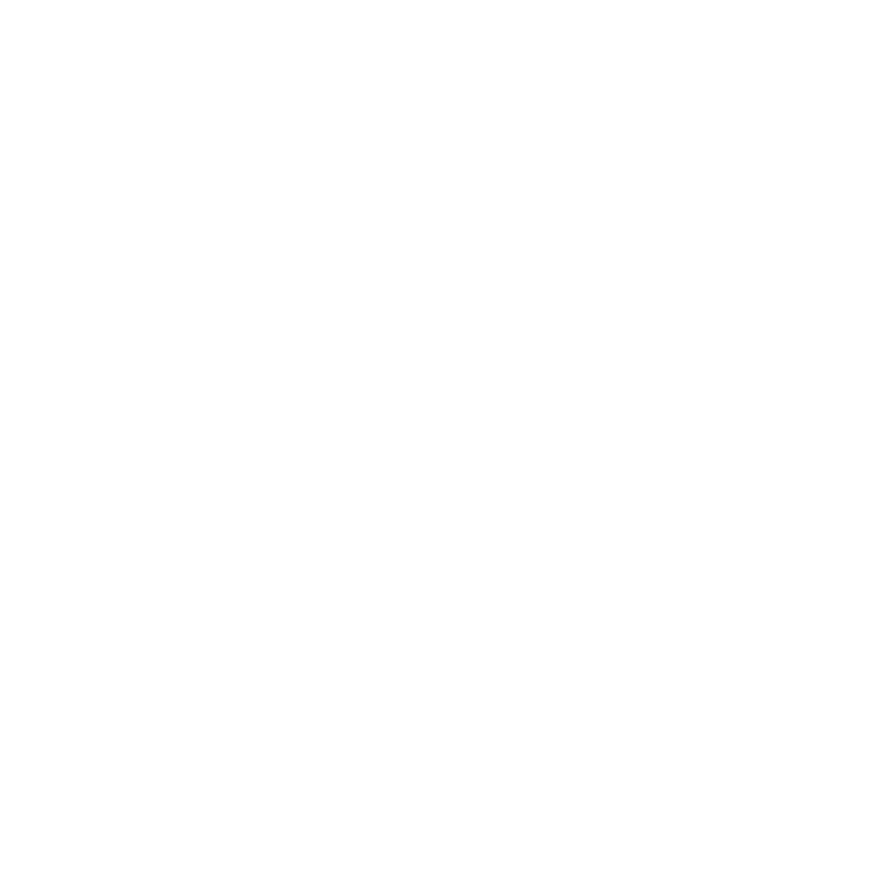

In [62]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph. Here the arrows point towards the composers. For instance, A.R. Rahman, who is a renowned music composer, has entities like “soundtrack score”, “film score”, and “music” connected to him in the graph above.

Let’s check out a few more relations.

Since writing is an important role in any movie, I would like to visualize the graph for the “written by” relation

In [23]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

NameError: name 'kg_df' is not defined

This knowledge graph is giving us some extraordinary information. Guys like Javed Akhtar, Krishna Chaitanya, and Jaideep Sahni are all famous lyricists and this graph beautifully captures this relationship.

Let’s see the knowledge graph of another important predicate, i.e., the “released in”

In [24]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

NameError: name 'kg_df' is not defined

#### Resources


https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/